In [1]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../src/')
from evaluate import get_results
from omegaconf import OmegaConf

In [2]:
# Initialize wandb (replace 'your_entity' and 'your_project' with your specific details)
wandb.login()
api = wandb.Api()

# Specify your entity, project, and sweep ID
entity = "xingzhis"
project = "dmae"
sweep_id = 'gbfsbi1b'

# Fetch the sweep
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

run_ids = [run.id for run in sweep.runs]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin


In [3]:
summary_list, config_list, name_list, id_list = [], [], [], []
for run in sweep.runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        OmegaConf.create(run.config))

    # .name is the human-readable name of the run.
    name_list.append(run.name)
    id_list.append(run.id)

runs_df = pd.DataFrame({
    "id": id_list,
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

In [4]:
runs_df['data'] = runs_df['config'].apply(lambda x: x.data.name)
runs_df['dropout'] = runs_df['config'].apply(lambda x: x.model.dropout)
runs_df['batch_norm'] = runs_df['config'].apply(lambda x: x.model.batch_norm)
runs_df['weight_decay'] = runs_df['config'].apply(lambda x: x.model.weight_decay)
runs_df['dist_mse_decay'] = runs_df['config'].apply(lambda x: x.model.dist_mse_decay)
runs_df['cycle_weight'] = runs_df['config'].apply(lambda x: x.model.cycle_weight)
runs_df['cycle_dist_weight'] = runs_df['config'].apply(lambda x: x.model.cycle_dist_weight)
runs_df['train/dist_accuracy_epoch'] = runs_df['summary'].apply(lambda x: x['train/dist_accuracy_epoch'])
runs_df['validation/dist_accuracy'] = runs_df['summary'].apply(lambda x: x['validation/dist_accuracy'])

In [5]:
baseline_id = (runs_df['data'] == 'eb_subset') & \
              (runs_df['dropout'] == 0) & \
              (runs_df['batch_norm'] == False) & \
              (runs_df['weight_decay'] == 0) & \
              (runs_df['dist_mse_decay'] == 0) & \
              (runs_df['cycle_weight'] == 0) & \
              (runs_df['cycle_dist_weight'] == 0)

In [6]:
runs_df[baseline_id]

,id,summary,config,name,data,dropout,batch_norm,weight_decay,dist_mse_decay,cycle_weight,cycle_dist_weight,train/dist_accuracy_epoch,validation/dist_accuracy
107,808xey79,"{'val_loss': 85.7441635131836, 'validation/dis...","[data, path, model, logger, model.lr, training...",generous-sweep-325,eb_subset,0.0,False,0.0,0.0,0,0,0.903461,0.788173


In [7]:
baseline_run_id = runs_df[baseline_id].sort_values('validation/dist_accuracy', ascending=False)['id'].iloc[0]

In [8]:
regularize_id = (runs_df['data'] == 'eb_subset') & \
              (runs_df['dropout'] == 0.2) & \
              (runs_df['batch_norm'] == True) & \
              (runs_df['weight_decay'] == 0.00001) & \
              (runs_df['dist_mse_decay'] == 0) & \
              (runs_df['cycle_weight'] == 0) & \
              (runs_df['cycle_dist_weight'] == 0)

In [9]:
runs_df[regularize_id]

,id,summary,config,name,data,dropout,batch_norm,weight_decay,dist_mse_decay,cycle_weight,cycle_dist_weight,train/dist_accuracy_epoch,validation/dist_accuracy
207,rf5fp0ep,"{'validation/dist_loss': 47.083282470703125, '...","[data, path, model, logger, model.lr, training...",sunny-sweep-225,eb_subset,0.2,True,0.00001,0.0,0,0,0.822529,0.836361


In [10]:
regularize_run_id = runs_df[regularize_id].sort_values('validation/dist_accuracy', ascending=False)['id'].iloc[0]

In [11]:
mse_decay_id = (runs_df['data'] == 'eb_subset') & \
              (runs_df['dropout'] != 0) & \
              (runs_df['batch_norm'] == True) & \
              (runs_df['weight_decay'] != 0) & \
              (runs_df['dist_mse_decay'] != 0) & \
              (runs_df['cycle_weight'] == 0) & \
              (runs_df['cycle_dist_weight'] == 0)

In [12]:
runs_df[mse_decay_id].sort_values('validation/dist_accuracy', ascending=False).head()

,id,summary,config,name,data,dropout,batch_norm,weight_decay,dist_mse_decay,cycle_weight,cycle_dist_weight,train/dist_accuracy_epoch,validation/dist_accuracy
190,wigqerd7,"{'_step': 724, 'validation/dist_accuracy': 0.8...","[data, path, model, logger, model.lr, training...",splendid-sweep-242,eb_subset,0.2,True,0.00010,0.5,0,0,0.835655,0.853539
199,8q6u3aqr,{'train/reconstr_loss_step': 1.623783230781555...,"[data, path, model, logger, model.lr, training...",volcanic-sweep-233,eb_subset,0.2,True,0.00010,0.2,0,0,0.825402,0.849644
198,nfq1vv4c,"{'distance_distortion': 0.2538267970085144, 'v...","[data, path, model, logger, model.lr, training...",cerulean-sweep-234,eb_subset,0.2,True,0.00001,0.2,0,0,0.821792,0.845901
189,ca0zgeb1,"{'epoch': 25, 'train_loss_step': 30.5247421264...","[data, path, model, logger, model.lr, training...",comic-sweep-243,eb_subset,0.2,True,0.00001,0.5,0,0,0.827934,0.844403
193,1o7n0b85,"{'_step': 618, 'procrustes_disparity_latent': ...","[data, path, model, logger, model.lr, training...",golden-sweep-239,eb_subset,0.5,True,0.00010,0.5,0,0,0.712689,0.805741


In [13]:
mse_decay_run_id = runs_df[mse_decay_id].sort_values('validation/dist_accuracy', ascending=False)['id'].iloc[0]

In [14]:
cycle_id = (runs_df['data'] == 'eb_subset') & \
              (runs_df['dropout'] != 0) & \
              (runs_df['batch_norm'] == True) & \
              (runs_df['weight_decay'] != 0) & \
              (runs_df['dist_mse_decay'] != 0) & \
              ((runs_df['cycle_weight'] != 0) | \
              (runs_df['cycle_dist_weight'] != 0))

In [15]:
runs_df[cycle_id].sort_values("validation/dist_accuracy", ascending=False).head()

,id,summary,config,name,data,dropout,batch_norm,weight_decay,dist_mse_decay,cycle_weight,cycle_dist_weight,train/dist_accuracy_epoch,validation/dist_accuracy
117,kb9bxlqg,"{'train/dist_loss_epoch': 41.80948257446289, '...","[data, path, model, logger, model.lr, training...",fine-sweep-315,eb_subset,0.2,True,0.00001,0.2,1,1,0.828283,0.845159
108,t0bhsry1,{'procrustes_disparity_reconstruction': 0.7315...,"[data, path, model, logger, model.lr, training...",smart-sweep-324,eb_subset,0.2,True,0.00001,0.5,1,1,0.835628,0.844508
109,dpxdy1qt,"{'_runtime': 1534.1868295669556, 'validation/r...","[data, path, model, logger, model.lr, training...",floral-sweep-323,eb_subset,0.2,True,0.00010,0.5,1,1,0.834028,0.842440
135,gnc4981e,"{'_step': 618, 'train/dist_accuracy_step': 0.8...","[data, path, model, logger, model.lr, training...",sweepy-sweep-297,eb_subset,0.2,True,0.00001,0.5,0,1,0.836532,0.840853
162,yvzcnjpv,{'train/dist_accuracy_step': 0.836372435092926...,"[data, path, model, logger, model.lr, training...",fine-sweep-270,eb_subset,0.2,True,0.00001,0.5,1,0,0.832834,0.840691


In [16]:
cycle_run_id = runs_df[cycle_id].sort_values('validation/dist_accuracy', ascending=False)['id'].iloc[0]

In [17]:
names_list = ['baseline', '+regularization', '+dist MSE decay', '+cycle loss']
run_ids_list = [baseline_run_id, regularize_run_id, mse_decay_run_id, cycle_run_id]
train_accs_list = [runs_df[runs_df['id'] == i]['train/dist_accuracy_epoch'].iloc[0] for i in run_ids_list]
valid_accs_list = [runs_df[runs_df['id'] == i]['validation/dist_accuracy'].iloc[0] for i in run_ids_list]

In [18]:
res_df = pd.DataFrame({
    'Name': names_list,
    'Run ID': run_ids_list,
    'Training Accuracy': train_accs_list,
    'Validation Accuracy': valid_accs_list
})


In [19]:
res_df

,Name,Run ID,Training Accuracy,Validation Accuracy
0,baseline,808xey79,0.903461,0.788173
1,+regularization,rf5fp0ep,0.822529,0.836361
2,+dist MSE decay,wigqerd7,0.835655,0.853539
3,+cycle loss,kb9bxlqg,0.828283,0.845159


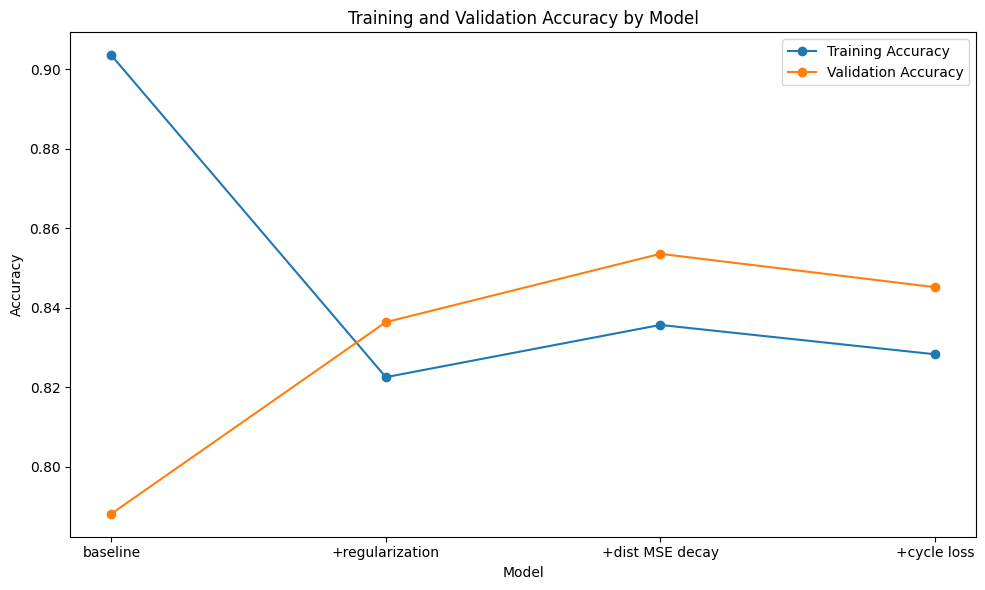

In [20]:
# Creating line plots with dots for Training and Validation Accuracy
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting
ax.plot(res_df['Name'], res_df['Training Accuracy'], marker='o', label='Training Accuracy', linestyle='-')
ax.plot(res_df['Name'], res_df['Validation Accuracy'], marker='o', label='Validation Accuracy', linestyle='-')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy by Model')
ax.legend()

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
res_list = []
for name, run_id in zip(res_df['Name'], res_df['Run ID']):
    run = api.run(f"{entity}/{project}/{run_id}")
    res, plots, cfg = get_results(run)
    res_list.append(
        dict(
            name=name,
            run_id=run_id,
            res=res,
            plots=plots,
            cfg=cfg
        )
    )

In [22]:
test_accs_list = [1 - res['res']['dist_mape_test_test'] for res in res_list]

In [23]:
test_accs_list

[0.687846980813132, 0.8180639007917341, 0.8141973963264446, 0.8208191622795038]

In [24]:
overall_accs_list = [1 - res['res']['dist_mape_test_overall'] for res in res_list]

In [25]:
overall_accs_list

[0.7393888685296583,
 0.8407077220232033,
 0.8321302331632058,
 0.8377405808142252]

In [26]:
test_train_accs_list = [1 - res['res']['dist_mape_test_train'] for res in res_list]

In [27]:
test_train_accs_list

[0.7522743404587897,
 0.8463686773310707,
 0.8366134423723961,
 0.8419709354479055]

In [28]:
res_df['Test Accuracy'] = test_accs_list

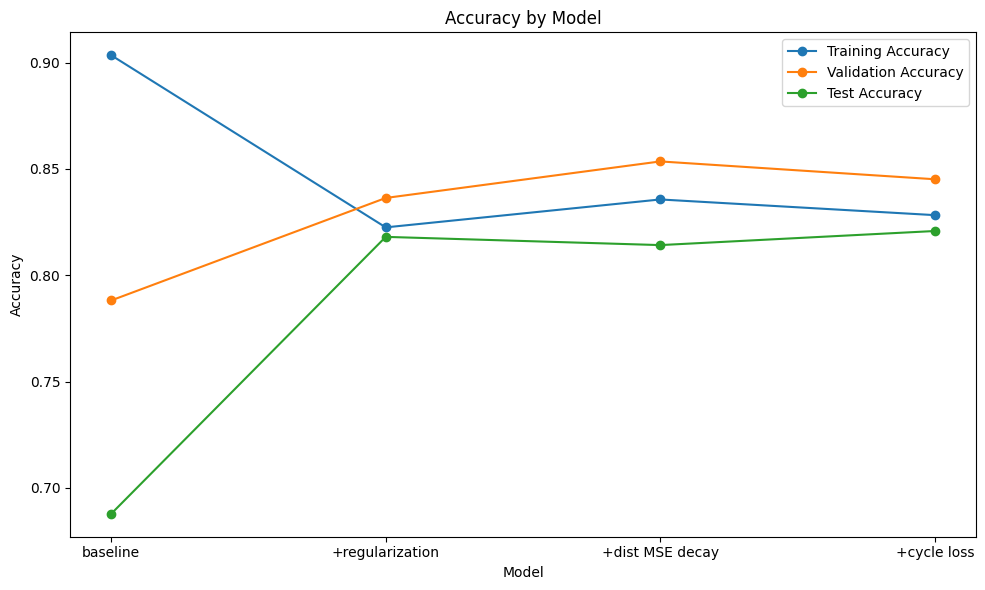

In [29]:
# Creating line plots with dots for Training and Validation Accuracy
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting
ax.plot(res_df['Name'], res_df['Training Accuracy'], marker='o', label='Training Accuracy', linestyle='-')
ax.plot(res_df['Name'], res_df['Validation Accuracy'], marker='o', label='Validation Accuracy', linestyle='-')
ax.plot(res_df['Name'], res_df['Test Accuracy'], marker='o', label='Test Accuracy', linestyle='-')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Model')
ax.legend()

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


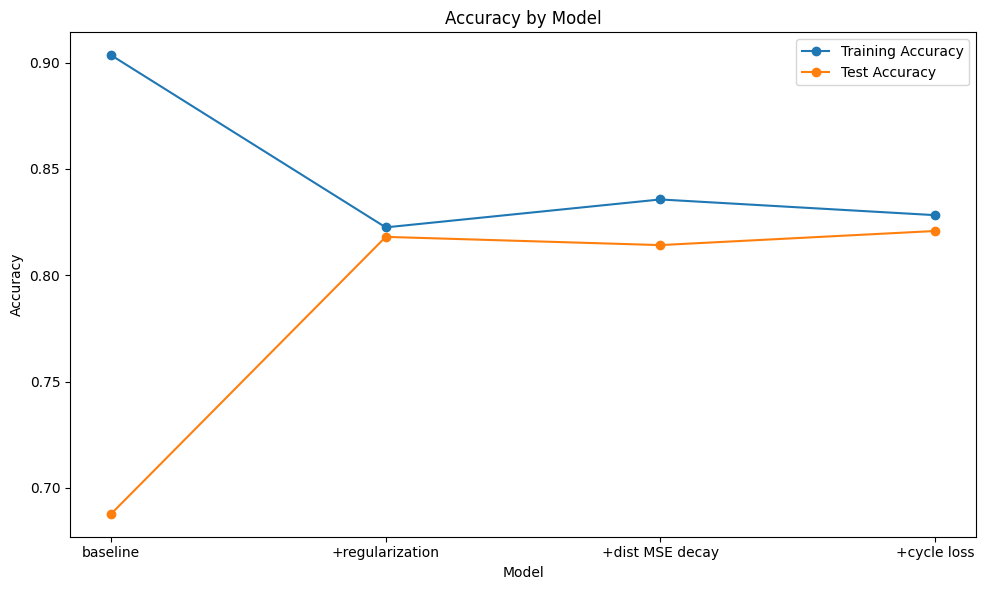

In [30]:
# Creating line plots with dots for Training and Validation Accuracy
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting
ax.plot(res_df['Name'], res_df['Training Accuracy'], marker='o', label='Training Accuracy', linestyle='-')
# ax.plot(res_df['Name'], res_df['Validation Accuracy'], marker='o', label='Validation Accuracy', linestyle='-')
ax.plot(res_df['Name'], res_df['Test Accuracy'], marker='o', label='Test Accuracy', linestyle='-')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Model')
ax.legend()

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [31]:
res_dict = {}
for res in res_list:
    res_dict[res['name']] = res

In [32]:
res_baseline = res_dict['baseline']
ptruetrain = res_baseline['plots']['phate_true_train'] # baseline
ptrain = res_baseline['plots']['phate_pred_train'] # baseline
ctrain = res_baseline['plots']['colors_train']
ptruetest = res_baseline['plots']['phate_true']
ptest = res_baseline['plots']['phate_pred']
ctest = res_baseline['plots']['colors']

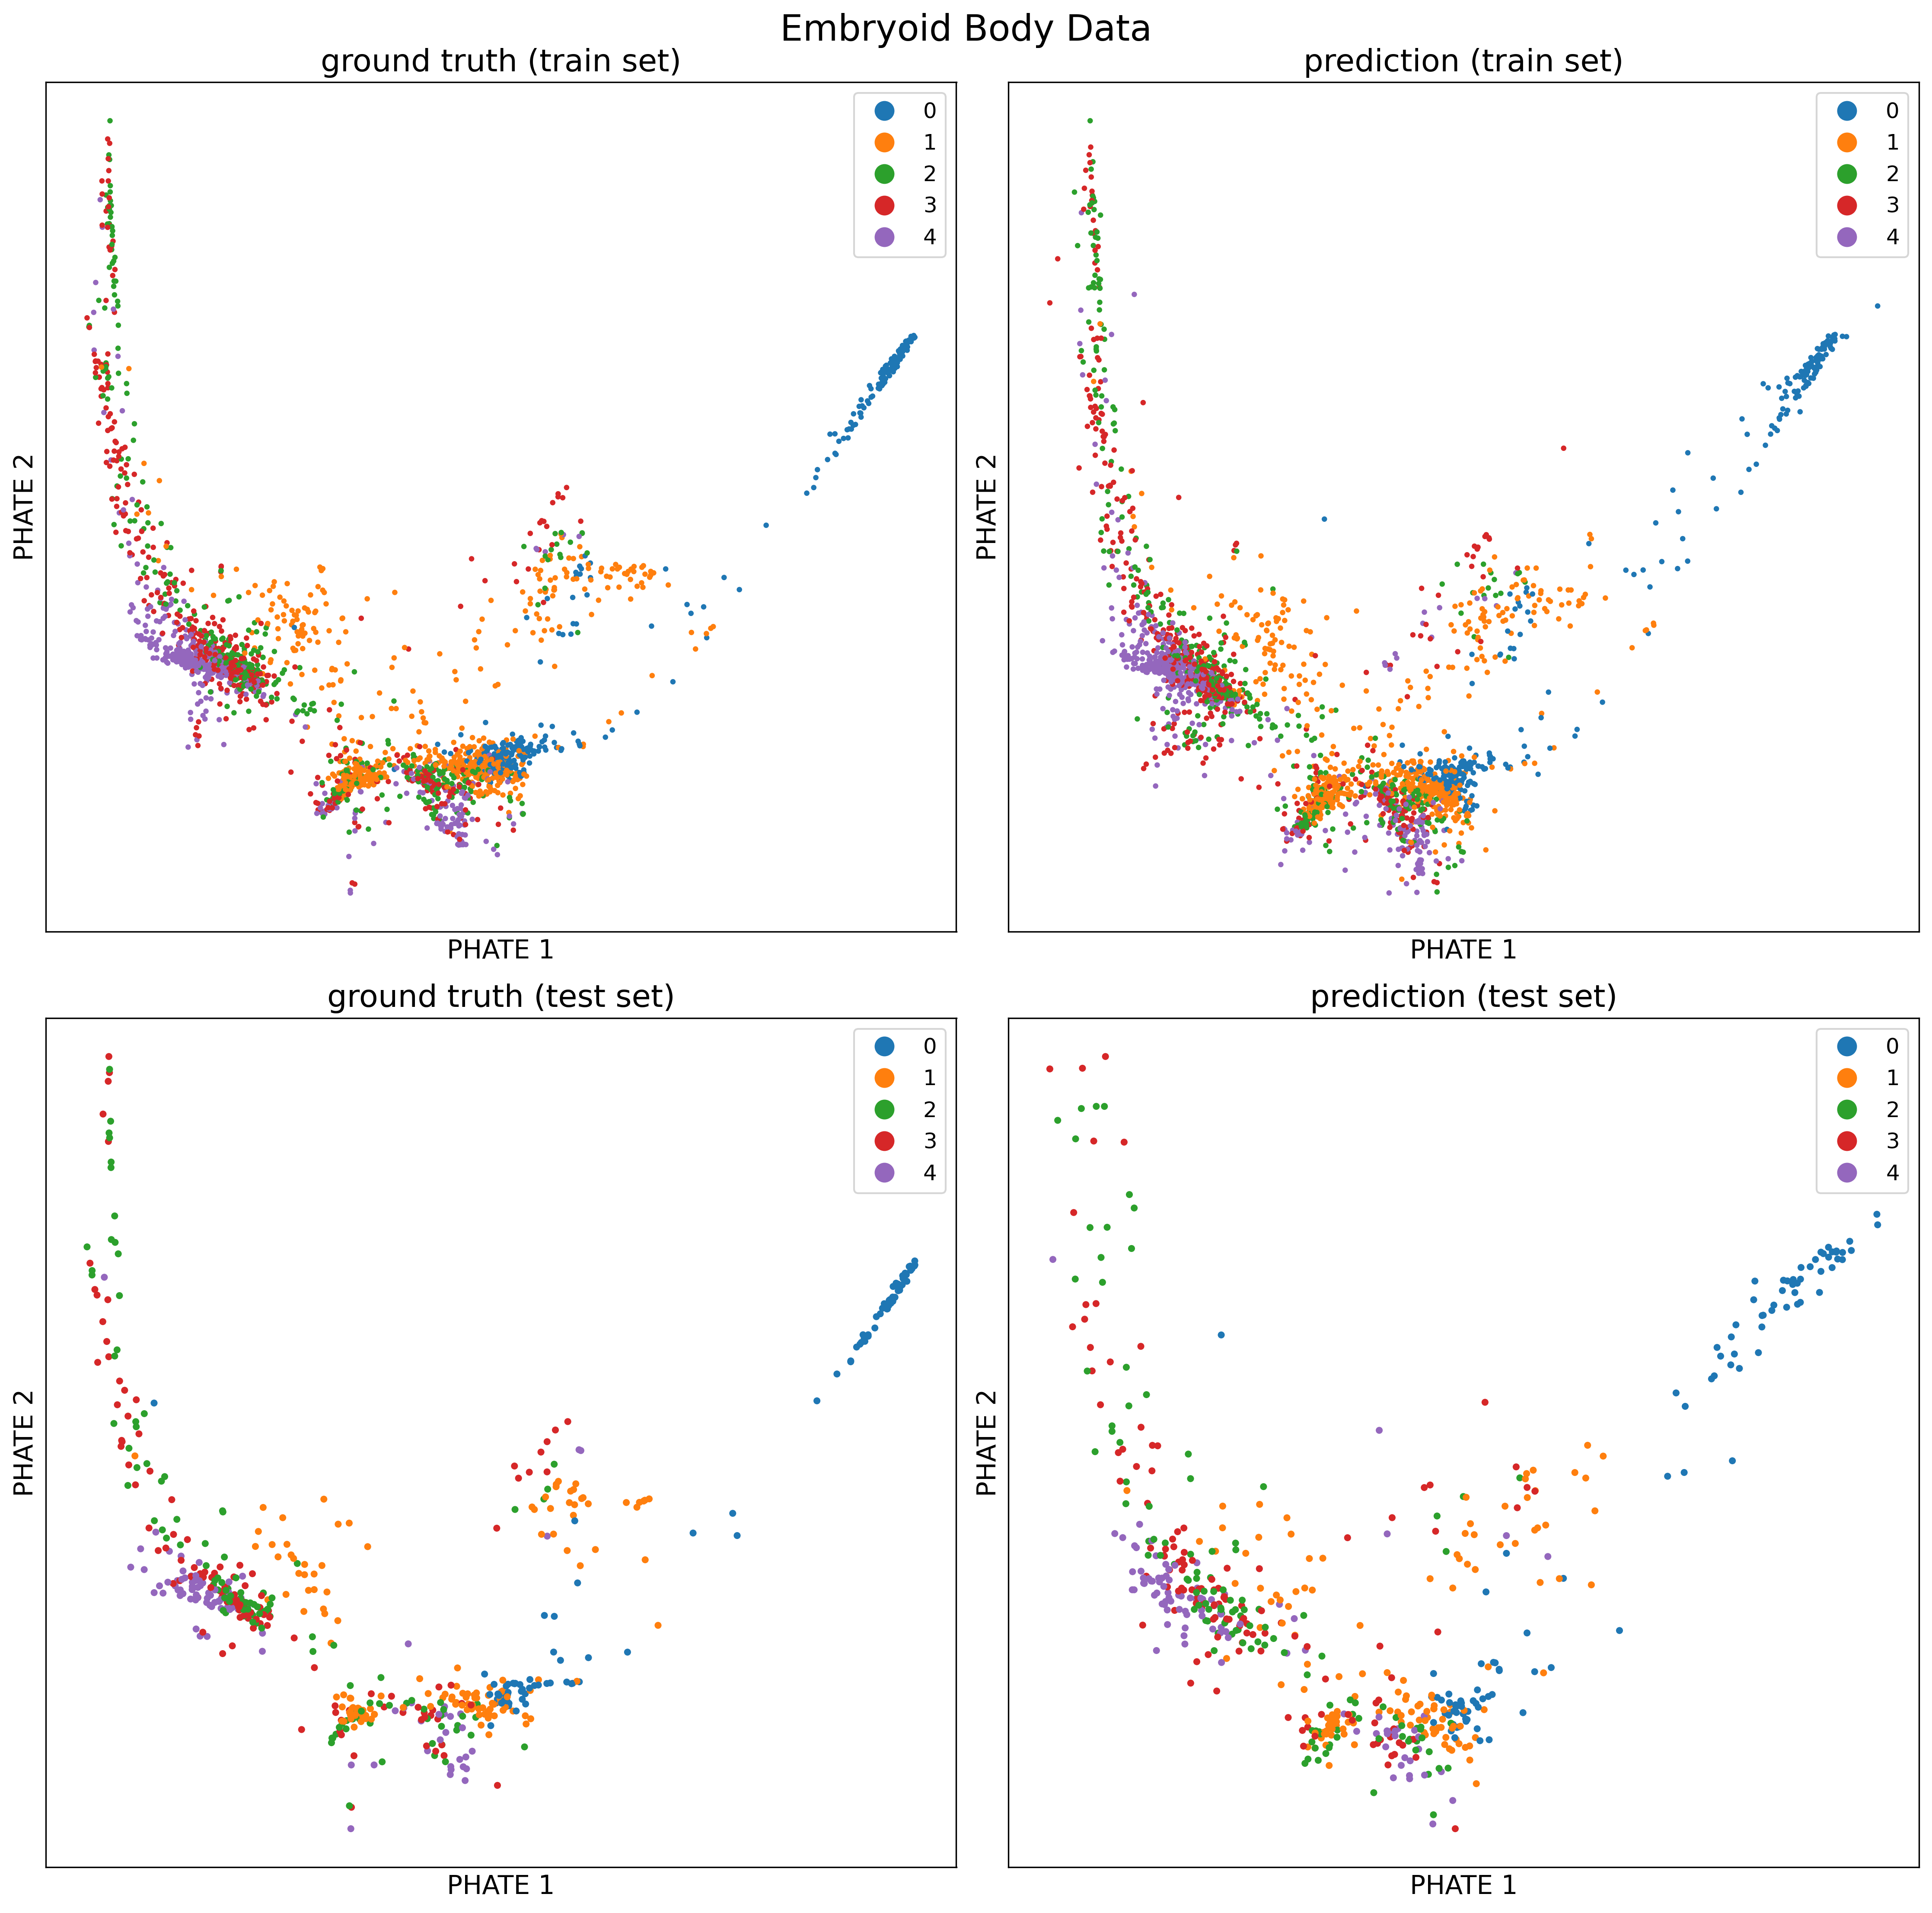

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(15,15), dpi=300)
scprep.plot.scatter2d(ptruetrain, c=ctrain, ax=axes[0,0], ticks=False, label_prefix="PHATE ", title='ground truth (train set)')
scprep.plot.scatter2d(ptrain, c=ctrain, ax=axes[0,1], ticks=False, label_prefix="PHATE ", title='prediction (train set)')
scprep.plot.scatter2d(ptruetest, c=ctest, ax=axes[1,0], ticks=False, label_prefix="PHATE ", title='ground truth (test set)')
scprep.plot.scatter2d(ptest, c=ctest, ax=axes[1,1], ticks=False, label_prefix="PHATE ", title='prediction (test set)')
plt.suptitle(f"Embryoid Body Data", fontsize=20)
plt.tight_layout()
plt.show()

In [34]:
res_list[0]['plots'].keys()

dict_keys(['phate_true', 'phate_pred', 'colors', 'colors_train', 'dist_true_test_test', 'dist_pred_test_test', 'dist_true_test_train', 'dist_pred_test_train', 'phate_true_train', 'phate_pred_train', 'dist_true_train_train', 'dist_pred_train_train'])

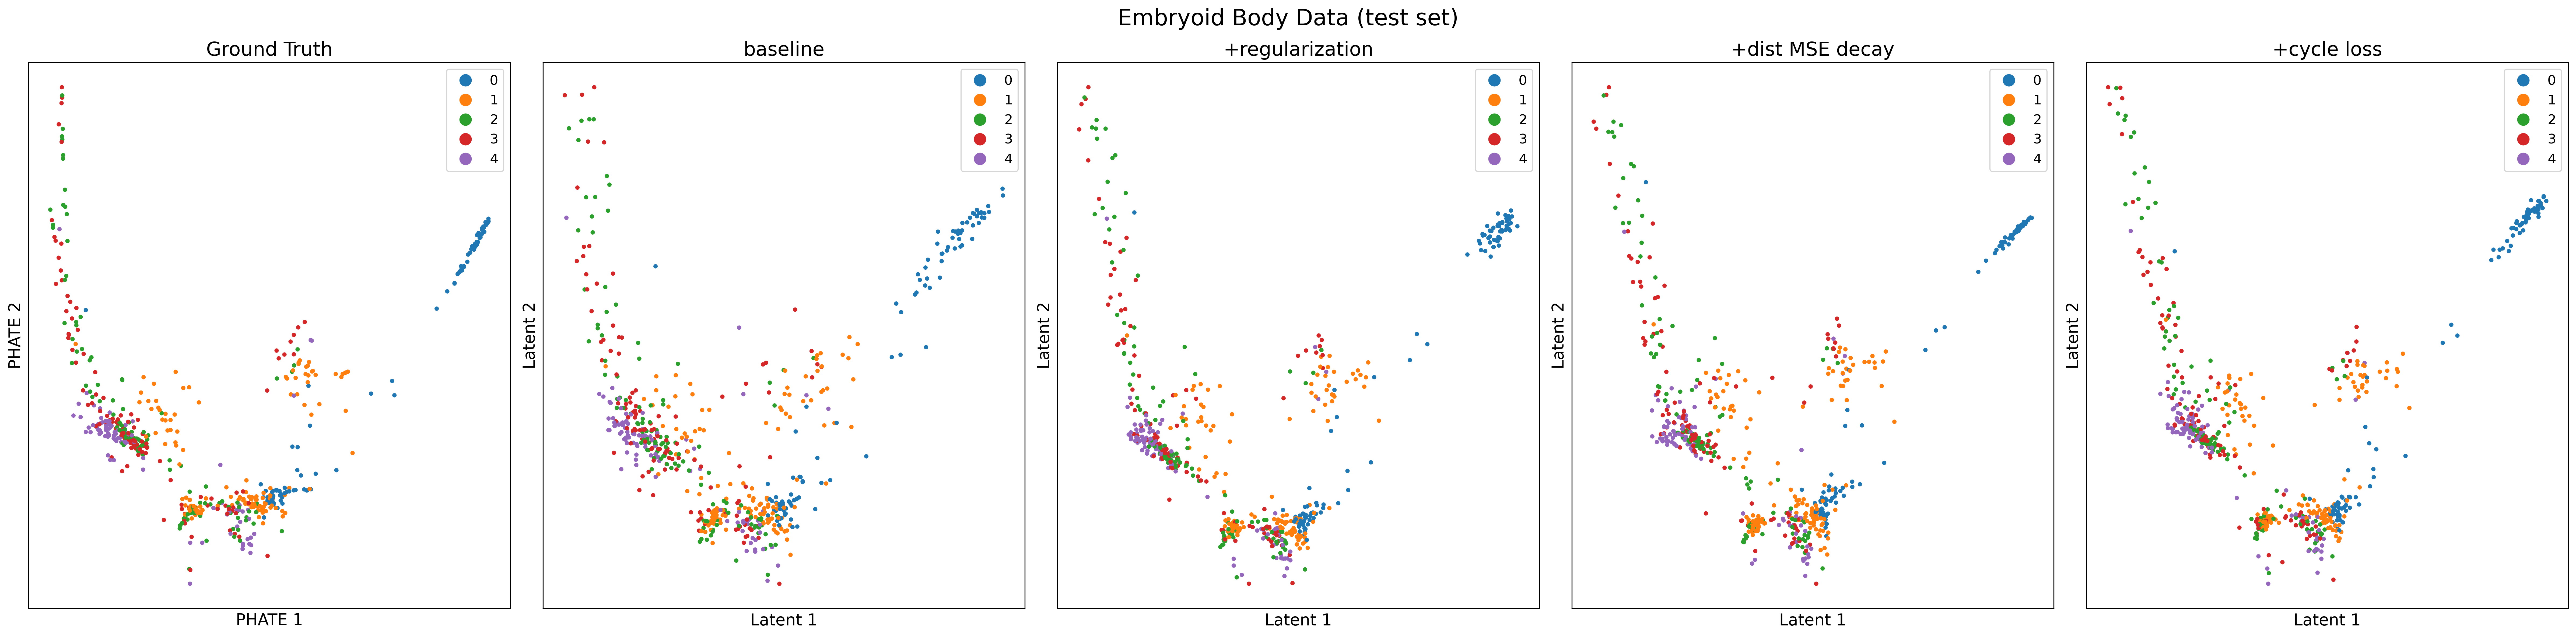

In [35]:
fig, axes = plt.subplots(1, len(res_dict)+1, figsize=(len(res_dict) * 8, 8), dpi=300)  # Modify the number of subplots to 3, adjust the figsize, and set dpi to 300

res = res_dict['baseline']
scprep.plot.scatter2d(res['plots']['phate_true'], c=res['plots']['colors'], ax=axes[0], ticks=False, label_prefix="PHATE ", title='Ground Truth')

for i, name in enumerate(res_df['Name']):
    ax = axes[i+1]
    res = res_dict[name]
    scprep.plot.scatter2d(res['plots']['phate_pred'], c=res['plots']['colors'], ax=axes[i+1], ticks=False, label_prefix="Latent ", title=name)
plt.suptitle(f"Embryoid Body Data (test set)", fontsize=20)
plt.tight_layout()
plt.show()

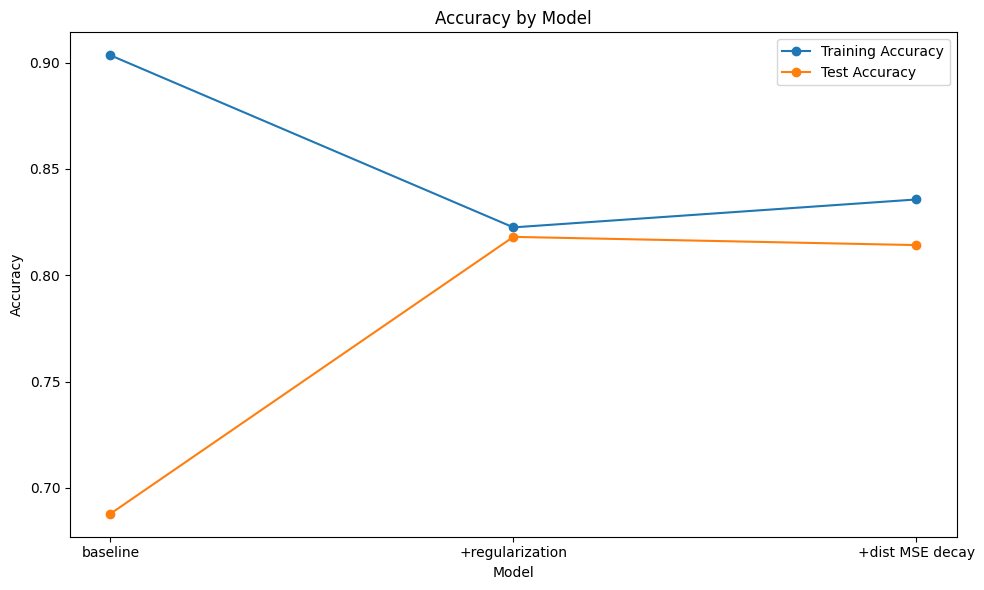

In [36]:
res_df2 = res_df[res_df['Name'] != '+cycle loss']
# Creating line plots with dots for Training and Validation Accuracy
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting
ax.plot(res_df2['Name'], res_df2['Training Accuracy'], marker='o', label='Training Accuracy', linestyle='-')
# ax.plot(res_df2['Name'], res_df2['Validation Accuracy'], marker='o', label='Validation Accuracy', linestyle='-')
ax.plot(res_df2['Name'], res_df2['Test Accuracy'], marker='o', label='Test Accuracy', linestyle='-')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Model')
ax.legend()

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


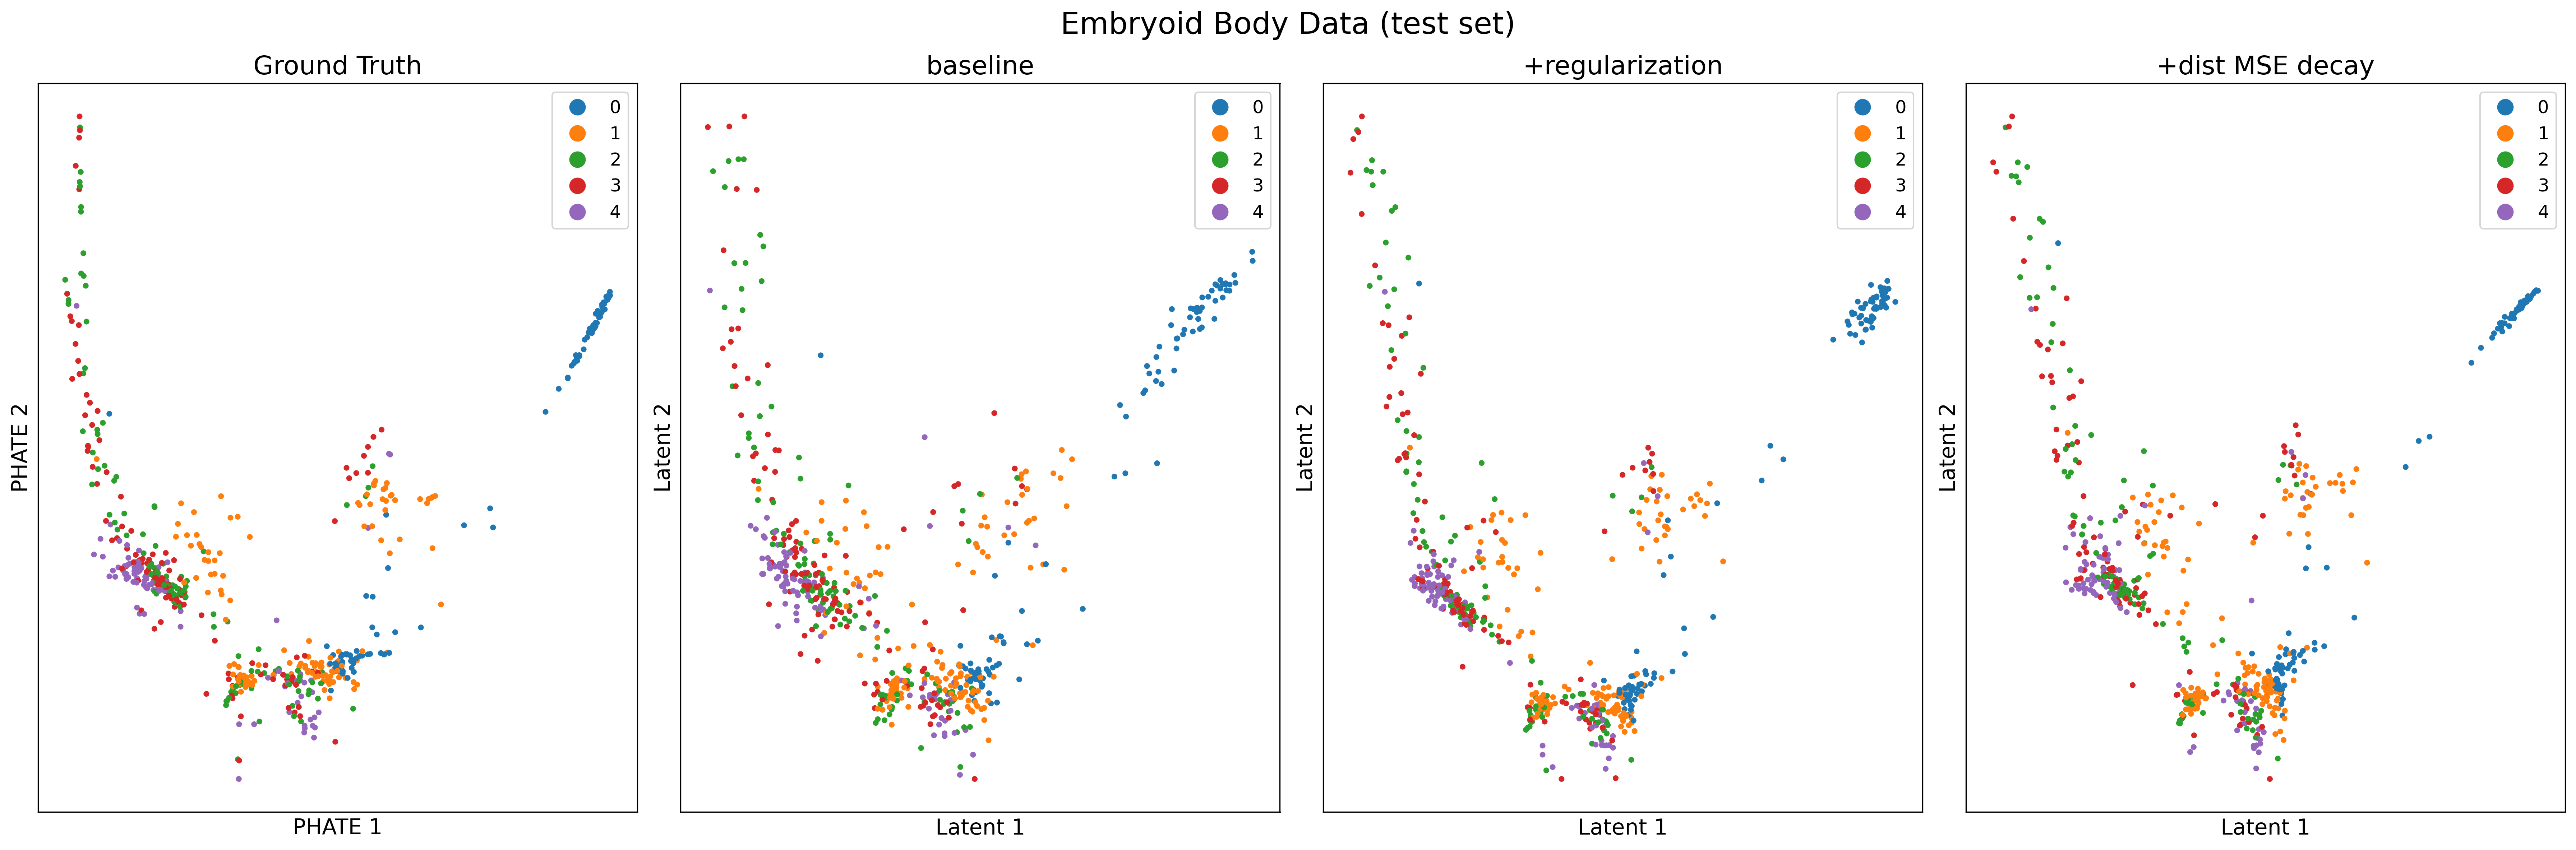

In [37]:
res_dict2 = {name: res_dict[name] for name in res_dict.keys() if name != '+cycle loss'}
fig, axes = plt.subplots(1, len(res_dict2)+1, figsize=(len(res_dict2) * 8, 8), dpi=300)  # Modify the number of subplots to 3, adjust the figsize, and set dpi to 300

res = res_dict2['baseline']
scprep.plot.scatter2d(res['plots']['phate_true'], c=res['plots']['colors'], ax=axes[0], ticks=False, label_prefix="PHATE ", title='Ground Truth')

for i, name in enumerate(res_df2['Name']):
    ax = axes[i+1]
    res = res_dict2[name]
    scprep.plot.scatter2d(res['plots']['phate_pred'], c=res['plots']['colors'], ax=axes[i+1], ticks=False, label_prefix="Latent ", title=name)
plt.suptitle(f"Embryoid Body Data (test set)", fontsize=20)
plt.tight_layout()
plt.show()